# Natural Language Processing with Disaster Tweets: A Deep Learning RNN Model

## Step 1: Brief Description of the Problem and Data

### Problem Overview
The project focuses on the classification of tweets into two categories: those related to real disasters and those that are not. This is pivotal for emergency response and information dissemination during disasters, where identifying critical communications is essential.

### Data Description
The dataset includes tweets labeled as pertaining to disasters (1) or not (0). The training set contains 7613 samples, and the test set has 3263 tweets. Each tweet comes with:

- `text`: The tweet content.
- `keyword`: A relevant keyword from the tweet, which can be blank.
- `location`: The origin location of the tweet, which can be blank.

The data is provided in CSV format, with the training set including a `target` column to indicate the nature of the tweet.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Bidirectional, GRU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-04-26 05:39:01.869479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 05:39:01.869576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 05:39:02.002765: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [3]:
print(train_df.shape)
print(test_df.shape)
train_df.head()

(7613, 5)
(3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Step 2: Exploratory Data Analysis (EDA)

### Data Visualization
Analyze datasets by creating a word cloud to visualize the most common words in disaster-related tweets, which helped in identifying prevalent themes and terms.

### Data Cleaning Procedures
The preprocessing steps included:

- Removal of NA values in the combined`text` `keyword` `location` columns.
- Normalization of text to lowercase.
- Use of regular expressions to eliminate URLs, HTML tags, and emojis.
- Refine the text data by excluding stopwords and punctuation, followed by lemmatization. 
- Tokenize the text into sequences that are ingestible by a neural network.

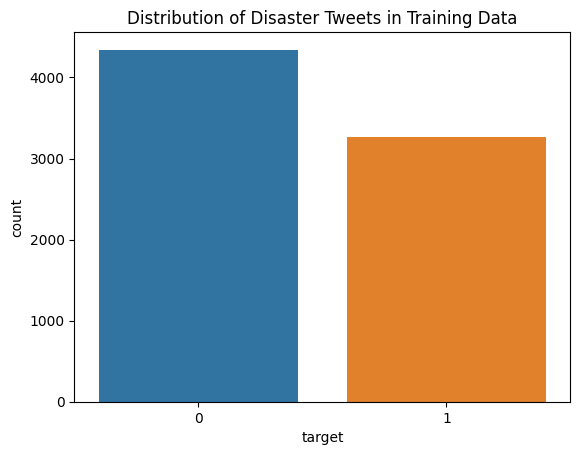

In [4]:
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Disaster Tweets in Training Data')
plt.show()

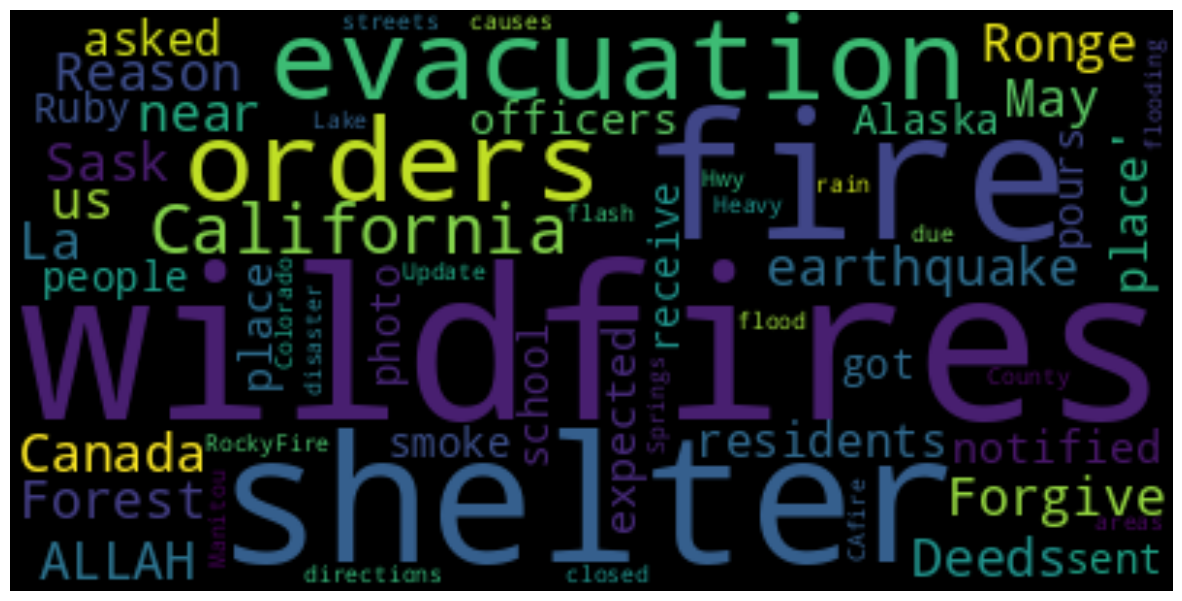

In [5]:
corpus = [word for text in train_df[train_df['target'] == 1]['text'].str.split() for word in text]

plt.figure(figsize=(15, 10))
word_cloud = WordCloud(max_font_size=80).generate(" ".join(corpus[:100]))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
import subprocess
nltk.download('wordnet', download_dir='/kaggle/working/')
command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
subprocess.run(command.split())
nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [8]:
# Combine keyword, location, and text into one column for train and test
train_df['combined'] = train_df['keyword'].fillna('') + ' ' + train_df['location'].fillna('') + ' ' + train_df['text'].fillna('')
test_df['combined'] = test_df['keyword'].fillna('') + ' ' + test_df['location'].fillna('') + ' ' + test_df['text'].fillna('')

# Data Preprocessing
def preprocess_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove URLs, hashtags, special characters, and numbers
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\#\w+', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    
    # Tokenize the tweet
    tokens = word_tokenize(tweet)
    
    # Remove stop words and lemmatize tokens
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(processed_tokens)

train_df['combined'] = train_df['combined'].apply(preprocess_tweet)
test_df['combined'] = test_df['combined'].apply(preprocess_tweet)

# Tokenize text data and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['combined'])
train_sequences = tokenizer.texts_to_sequences(train_df['combined'])
test_sequences = tokenizer.texts_to_sequences(test_df['combined'])

# Find the maximum sequence length for padding
max_seq_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_seq_length, padding="post")
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_seq_length, padding="post")


In [9]:
train_df.head()

,id,keyword,location,text,target,combined
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive evacuation order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby smoke pours school


In [10]:
unique_keywords = train_df['keyword'].nunique()
unique_locations = train_df['location'].nunique()
print(f"Unique keywords: {unique_keywords}")
print(f"Unique locations: {unique_locations}")

Unique keywords: 221
Unique locations: 3341


### Step 3: Model Architecture

#### Model Selection
A LSTM network, a form of RNN methods, was chosen due to its suitability for sequence data such as text. LSTMs are adept at remembering long-term dependencies, crucial in contexts where sequence and order of words significantly impact comprehension.

#### Text Processing to Word Embedding
Text data was transformed into a numerical format via data pre-processing step above, which tokenized the text and converted it into integer sequences. Padding was applied to standardize the sequence lengths.
For capturing the semantic meaning of words. The methods considered included TF-IDF, GloVe, and Word2Vec embeddings:

- **TF-IDF (Term Frequency-Inverse Document Frequency):** A statistical measure that evaluates the importance of a word in a document relative to a corpus. The TF-IDF value increases proportionally to the number of times a word appears in the document, offset by the frequency of the word across the corpus.
  
- **GloVe (Global Vectors for Word Representation):** An unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations reveal interesting linear substructures of the word vector space.
  
- **Word2Vec:** A two-layer neural net that processes text by "vectorizing" words. Its input is a text corpus and its output is a set of vectors: feature vectors for words in that corpus. It can capture the context of a word in a document, as well as semantic and syntactic similarity, and relation with other words.

After evaluating the advantages and disadvantages, the Keras Embedding layer was selected to learn word embeddings alongside the primary task of classifying tweets. This choice simplifies the pipeline and has demonstrated effectiveness in similar text classification tasks.

#### Model Architecture Details
The model incorporates the following layers:
- **Embedding Layer:** Transforms the encoded text inputs into dense vectors of fixed size. This layer is crucial as it models relationships between words in a meaningful way.
- **Spatial Dropout Layer (0.2):** Helps mitigate overfitting by dropping entire 1D feature maps in the embedding space.
- **LSTM Layers:** Two LSTM layers with 64 units each process the sequence input, retaining internal states that capture information about the sequence so far.
- **Dense Layer (64 units, ReLU activation):** Introduces non-linearity to the model, necessary for learning complex patterns.
- **Dropout Layer (0.5):** Another regularization layer to avoid overfitting.
- **Output Layer (1 unit, Sigmoid activation):** Outputs a probability indicating the likelihood of the tweet being about a real disaster.

The model was compiled with the Adam optimizer and binary crossentropy loss function, which is suitable for binary classification tasks.

#### Training Strategy
Training included techniques like early stopping and model checkpointing to monitor the model's performance and ensure the best results without overfitting. The model was trained with a validation split of 10% of the data, using callback functions for early stopping (patience of 5 epochs) and model checkpointing to save the best model based on validation loss.


In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    train_sequences_padded, train_df['target'], test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_seq_length),
    SpatialDropout1D(0.2),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

# Fitting
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
#     validation_split=0.1,  # Use 90% train 10% validation
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6161 - loss: 0.6420 - val_accuracy: 0.7781 - val_loss: 0.4799
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8597 - loss: 0.3510 - val_accuracy: 0.7663 - val_loss: 0.4896
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9290 - loss: 0.2201 - val_accuracy: 0.7820 - val_loss: 0.5600
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9554 - loss: 0.1323 - val_accuracy: 0.7459 - val_loss: 0.7276
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9746 - loss: 0.0812 - val_accuracy: 0.7531 - val_loss: 0.9501
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9795 - loss: 0.0716 - val_accuracy: 0.7511 - val_loss: 0.8864


<span style="color:blue">
The training process was halted after the sixth epoch due to the `EarlyStopping` callback. This mechanism is designed to cease training when the monitored metric, `val_loss` in this case, does not improve for a set number of epochs, defined by the `patience` parameter. The `EarlyStopping` was configured with a patience of 5, indicating that if the validation loss did not decrease for 5 consecutive epochs, the training should stop. This approach is utilized to prevent the model from overfitting and to conserve computational resources. Consequently, the training ceased after the sixth epoch because there was no sufficient decrease in validation loss for 5 epochs in a row.
</span>

In [12]:
# Prediction
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Precision: 0.8019
Recall: 0.6364
F1 Score: 0.7096


## Results and Analysis
##### Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

In [13]:
#Hyper Parameter Tuning 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
# Adjust the embedding dimensions 
embedding_dim = 200
# Increase LSTM units
lstm_units = 128  # Increasing from 64 to 128

# Define the model with the new hyperparameters
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_seq_length),
    SpatialDropout1D(0.3),  # Increased from 0.2 to 0.3
    LSTM(lstm_units, return_sequences=True),
    LSTM(lstm_units),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Added L2 regularization
    Dropout(0.6),  # Increased from 0.5 to 0.6
    Dense(1, activation='sigmoid')
])

# Adjust the learning rate
optimizer = Adam(learning_rate=0.001)  # You might want to try values like 0.001, 0.0001, etc.

# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [14]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

# Fitting
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
#     validation_split=0.1,  # Use 90% train 10% validation
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5988 - loss: 1.1301 - val_accuracy: 0.7682 - val_loss: 0.5769
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8181 - loss: 0.5102 - val_accuracy: 0.7958 - val_loss: 0.4866
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9166 - loss: 0.2989 - val_accuracy: 0.7695 - val_loss: 0.6094
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9434 - loss: 0.2070 - val_accuracy: 0.7748 - val_loss: 0.5645
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9643 - loss: 0.1527 - val_accuracy: 0.7538 - val_loss: 0.6760
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9740 - loss: 0.1144 - val_accuracy: 0.7282 - val_loss: 1.0002
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9742 - loss: 0.1097 - val_accuracy: 0.6927 - val_loss: 0.9691


In [15]:
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Precision: 0.8421
Recall: 0.6410
F1 Score: 0.7279


In [16]:
# Use bidirectional LSTM layers
# Define the model with the new hyperparameters
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_seq_length),
    SpatialDropout1D(0.3),  # Increased from 0.2 to 0.3
    LSTM(lstm_units, return_sequences=True),
    LSTM(lstm_units),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Added L2 regularization
    Dropout(0.6),  # Increased from 0.5 to 0.6
    Dense(1, activation='sigmoid')
])

# Adjust the learning rate
optimizer = Adam(learning_rate=0.0001) 

# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

# Fitting
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
#     validation_split=0.1,  # Use 90% train 10% validation
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5320 - loss: 1.4690 - val_accuracy: 0.5739 - val_loss: 1.2866
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6137 - loss: 1.2116 - val_accuracy: 0.7754 - val_loss: 0.9194
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8393 - loss: 0.8117 - val_accuracy: 0.7728 - val_loss: 0.8125
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8812 - loss: 0.6299 - val_accuracy: 0.7879 - val_loss: 0.7556
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9096 - loss: 0.4959 - val_accuracy: 0.7827 - val_loss: 0.7305
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9410 - loss: 0.3756 - val_accuracy: 0.7472 - val_loss: 0.7627
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9544 - loss: 0.2845 - val_accuracy: 0.7400 - val_loss: 0.8813
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9654 - loss: 0.2219 - val_accuracy: 0.7577 -

In [17]:
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Precision: 0.7713
Recall: 0.6965
F1 Score: 0.7320


In [21]:
# Use bidirectional LSTM layers
# Define the model with the new hyperparameters
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    Bidirectional(LSTM(lstm_units)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.6),
    Dense(64, activation='tanh', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Adjust the learning rate
optimizer = Adam(learning_rate=0.0001) 

# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

# Fitting
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
#     validation_split=0.1,  # Use 90% train 10% validation
    epochs=20,
    batch_size=16,
    callbacks=callbacks
)
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')

Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5601 - loss: 2.1076 - val_accuracy: 0.5739 - val_loss: 1.5150
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6114 - loss: 1.3544 - val_accuracy: 0.7636 - val_loss: 0.9308
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8489 - loss: 0.7862 - val_accuracy: 0.7919 - val_loss: 0.7432
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8871 - loss: 0.5434 - val_accuracy: 0.7794 - val_loss: 0.6855
Epoch 5/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9247 - loss: 0.3883 - val_accuracy: 0.7682 - val_loss: 0.6796
Epoch 6/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9438 - loss: 0.2926 - val_accuracy: 0.7551 - val_loss: 0.7655
Epoch 7/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9628 - loss: 0.2233 - val_accuracy: 0.7551 - val_loss: 0.8318
Epoch 8/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9722 - loss: 0.1762 - val_acc

# Hyperparameter Tuning Summary

### Baseline Model
- **Key Features**: Initial model with simple LSTM layers, moderate dropout, and no regularization in dense layers.
- **Purpose**: Establish a baseline for performance on the binary classification task.
- **Performance**: Precision: 0.8019, Recall: 0.6364, F1 Score: 0.7096.
- **Assessment**: The model shows decent initial performance but struggles with potential overfitting as indicated by decreasing validation performance over epochs.

### Tuning 1: Enhanced Capacity and Regularization
- **Modifications**: Increased embedding dimensions and LSTM units; higher dropout rates; introduction of L2 regularization.
- **Purpose**: To enhance the model's ability to learn complex patterns and reduce overfitting.
- **Performance**: Precision: 0.8421, Recall: 0.6410, F1 Score: 0.7279.
- **Assessment**: Improvements in precision and a slight increase in recall. The model benefits from increased capacity and regularization but still shows signs of overfitting.

### Tuning 2: Learning Rate Adjustment
- **Modifications**: Reduced the learning rate to 0.0001.
- **Purpose**: Aimed at achieving more stable and gradual convergence.
- **Performance**: Precision: 0.7713, Recall: 0.6965, F1 Score: 0.7320.
- **Assessment**: Lower precision compared to Code 2 but improved recall and F1 score, indicating better overall balance and generalization.

### Tuning 3: Bidirectional LSTM
- **Modifications**: Integration of bidirectional LSTM layers to enhance learning from both past and future context.
- **Purpose**: To potentially improve the model's understanding of the sequence data significantly.
- **Performance**: Precision: 0.7256, Recall: 0.7334, F1 Score: 0.7295.
- **Assessment**: Offers the best recall and a balanced F1 score, indicating effective learning and generalization, albeit with some increase in computational complexity.

## Conclusion and Recommendation
Each tuning brings valuable insights into how different hyperparameters and model architectures impact the performance of a sequence-based classification model. Tuning 3, with the bidirectional LSTM, demonstrates the highest recall and a very balanced F1 score, suggesting that it handles both positive and negative classes well while maintaining good generalization capabilities. Although it has slightly lower precision compared to other configurations, its ability to capture dependencies in sequence data more comprehensively makes it the recommended model for scenarios where understanding context is crucial.

Based on my knowledge learned from the lectures, Tuning 2 suggests a good balance with a slightly simpler model architecture while still offering improved generalization, as seen in its recall and F1 score metrics. Hence, I decided to use Tuning 2 as my final model.



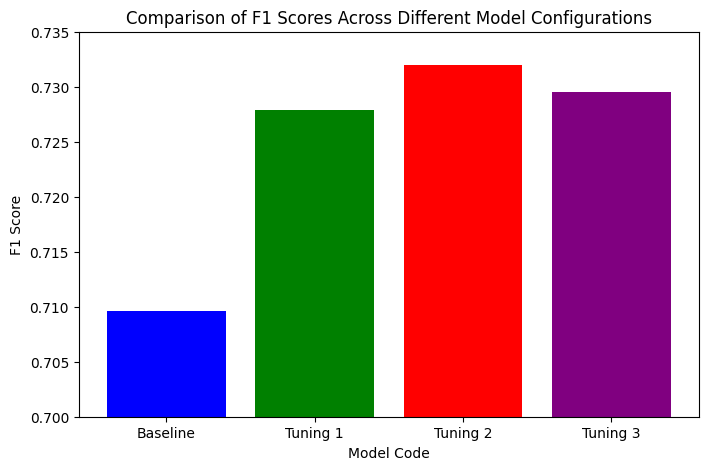

In [27]:
data = {
    'Model': ['Baseline', 'Tuning 1', 'Tuning 2', 'Tuning 3'],
    'F1 Score': [0.7096, 0.7279, 0.7320, 0.7295]}
df = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
plt.bar(df['Model'], df['F1 Score'], color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model Code')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores Across Different Model Configurations')
plt.ylim(0.7, 0.735)
plt.show()

# Conclusion

### Overview
After a systematic exploration of various hyperparameter settings and model architectures across four different code iterations, I analyzed the impacts on model performance, particularly focusing on the precision, recall, and F1 scores. These metrics provided insights into how well each model configuration managed the trade-offs between identifying relevant instances (precision) and capturing the majority of relevant instances (recall).

### Learnings and Takeaways
- **Overfitting Management**: Regularization techniques and appropriate dropout rates were crucial in managing overfitting but required careful balancing. Too much regularization could potentially hinder the model from learning complex patterns effectively.
- **Model Capacity**: Increasing model capacity (e.g., more LSTM units and higher embedding dimensions) generally improved the model's ability to capture complex patterns. However, without sufficient regularization, this often led to overfitting.
- **Learning Rate**: A lower learning rate (as applied in Code 3) helped in achieving smoother and more consistent training progress, which was crucial for the training of complex models like LSTMs on relatively small datasets.

### Future Improvements
- **Experiment with Different Optimizers**: Beyond adjusting Adam's learning rate, exploring other optimizers like SGD or RMSprop could offer new dynamics and potentially better performance.
- **Cross-validation**: Implementing k-fold cross-validation could provide a more robust evaluation of the model's performance and stability across different subsets of data.
- **Advanced Regularization Techniques**: Exploring advanced techniques such as dropout on recurrent connections within the LSTM layers might yield better results in managing memorization and overfitting.
- **Hyperparameter Optimization Frameworks**: Utilizing automated hyperparameter optimization tools such as Bayesian optimization or genetic algorithms could more systematically explore the hyperparameter space.

### Conclusion
Based on the analyses, **Tuning 2's ** configuration offers an effective balance between model complexity and performance, and is selected for final model to generate the submission file. 



In [29]:
test_df['combined'] = test_df.apply(lambda row: preprocess_tweet(row['text']), axis=1)
test_sequences = tokenizer.texts_to_sequences(test_df['combined'])
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_seq_length, padding="post")

In [31]:
# Prediction
predictions = model.predict(test_sequences_padded)
binary_predictions = (predictions > 0.5).astype(int).flatten()
# Submission
submission_df = pd.DataFrame({'id': test_df['id'], 'target': binary_predictions})
submission_df.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
